# Décrivez et nettoyez votre jeu de données
[Lien vers le cours](https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4726171-telechargez-les-donnees)

In [61]:
%matplotlib inline
import pandas as pd

## Importation du jeu de données personnelles

In [45]:
# Import du fichier personnel avec les bons arguments
data = pd.read_csv('data/export_boursorama.csv', 
                   delimiter=';', 
                   encoding="ISO-8859-15", 
                   parse_dates=[0,1], 
                   dayfirst=True, 
                   decimal=',')

# On met les mêmes noms de colonnes que le cours pour faciliter le travail
data.columns = ['date_operation', 'date_valeur', 'libelle',  'categorie',
                'categorie_parente', 'debiteur', 'montant', 'numero_compte', 'libelle_compte', 'solde']

# Je ne sais pas pourquoi Pandas refuse de convertir automatiquement la colonne "montant" en float
# J'ai du supprimer manuellement les virgules et les espaces pour que ça fonctionne
data['montant'] = [x.replace(',', '.') for x in data['montant']]
data['montant'] = [x.replace(' ', '') for x in data['montant']]
data['montant'] = data['montant'].astype(float)

data.head()

date_operation date_valeur                                   libelle  \
0     2021-04-15  2021-04-15                VIR INST LA BANQUE POSTALE   
1     2021-04-14  2021-04-14  CARTE 13/04/21 38 REGIE VOIRIE   CB*7929   
2     2021-04-14  2021-04-14  CARTE 13/04/21 38 PHARM. DU PEAG CB*7929   
3     2021-04-13  2021-04-13  CARTE 12/04/21 75 LeBonCoin      CB*7929   
4     2021-04-13  2021-04-13  CARTE 12/04/21 75 SNCF INTERNET  CB*7929   

                                           categorie     categorie_parente  \
0  Epargne financière (retraite, prévoyance, PEA,...    Dépenses d'épargne   
1                                     Santé - Autres                 Santé   
2                           Pharmacie et laboratoire                 Santé   
3                           Vie Quotidienne - Autres       Vie quotidienne   
4     Transports longue distance (avions, trains...)  Voyages & Transports   

             debiteur  montant  numero_compte      libelle_compte   solde  
0   la banque postale   -30.00       40658305  CPT  COMMUN MARINE  926.52  
1        regie voirie    -1.70       40658305  CPT  COMMUN MARINE  926.52  
2  pharmacie du peage    -7.70       40658305  CPT  COMMUN MARINE  926.52  
3           leboncoin   -55.19       40658305  CPT  COMMUN MARINE  926.52  
4                sncf  -215.20       40658305  CPT  COMMUN MARINE  926.52

## Détecter les opérations fréquentes

In [48]:
from collections import Counter

def most_common_words(labels):
    words = []
    for lab in labels:
        words += lab.split(" ")
    counter = Counter(words)
    for word in counter.most_common(100):
        print(word)

# most_common_words(data['libelle'].values)

In [50]:
# On crée alors les catégories persos en fonction de ça
CATEGS = {
    'NAGEOTTE': 'LOYER',
    'Emanuelle': 'LOYER',
    'MAIF': 'ASSURANCES',
    "REGIE": 'TRANSPORT',
    'TELEPHONE': 'TELEPHONE',
    'AREA': 'TRANSPORT ET ESSENCE',
    'DAC': 'TRANSPORT ET ESSENCE',
    'CARREFOUR': 'TRANSPORT ET ESSENCE',
    'CHEZ LUC': 'RESTAURANT',
    'PHARMACIE': 'PHARMACIE',
    'EPICERIE': 'COURSES',
    'JAY': 'COURSES',
    'EAU': 'COURSES',
    'VIVE': 'COURSES',
    'VIE': 'COURSES',
    'PAIN': 'COURSES',
    'CLAIRE': 'COURSES',
    'PETITSCULOTTES': 'BEBE'
}
TYPES = {
    'CARTE': 'CARTE',
    'CB*7929': 'CARTE',
    'CB*4910': 'CARTE',
    'VIR': 'VIREMENT',
    'VIREMENT': 'VIREMENT',
    'RETRAIT': 'RETRAIT',
    'PRLV': 'PRELEVEMENT',
    'DON': 'DON',
    'CHQ': 'CHEQUE'
}

In [51]:
# Bornes d'analyse de dépenses
EXPENSES = [50,200] # Bornes des catégories de dépense : petite, moyenne et grosse
LAST_BALANCE = 926 # Solde du compte APRES la dernière opération en date
WEEKEND = ["Saturday","Sunday"] # Jours non travaillés

## Code récupéré sur l'exercice

In [54]:
# Controle des colonnes
for c in ['date_operation','libelle','debit','credit']:
    if c not in data.columns:
        if (c in ['debit','credit'] and 'montant' not in data.columns) or \
        (c not in ['debit','credit']):
            msg = "Il vous manque la colonne '{}'. Attention aux majuscules "
            msg += "et minuscules dans le nom des colonnes!"
            raise Exception(msg.format(c))

# Suppression des colonnes innutiles
for c in data.columns:
    if c not in ['date_operation','libelle','debit','credit','montant']:
        del data[c]

# Ajout de la colonne 'montant' si besoin
if 'montant' not in data.columns:
    data["debit"] = data["debit"].fillna(0)
    data["credit"] = data["credit"].fillna(0)
    data["montant"] = data["debit"] + data["credit"]
    del data["credit"], data["debit"]

# creation de la variable 'solde_avt_ope'
data = data.sort_values("date_operation")
amount = data["montant"]
balance = amount.cumsum()
balance = list(balance.values)
last_val = balance[-1]
balance = [0] + balance[:-1]
balance = balance - last_val + LAST_BALANCE
data["solde_avt_ope"] = balance

# Assignation des operations a une categorie et a un type
def detect_words(values, dictionary):
    result = []
    for lib in values:
        operation_type = "AUTRE"
        for word, val in dictionary.items():
            if word in lib:
                operation_type = val
        result.append(operation_type)
    return result
data["categ"] = detect_words(data["libelle"], CATEGS)
data["type"] = detect_words(data["libelle"], TYPES)

# creation des variables 'tranche_depense' et 'sens'
def expense_slice(value):
    value = -value # Les dépenses sont des nombres négatifs
    if value < 0:
        return "(pas une dépense)"
    elif value < EXPENSES[0]:
        return "petite"
    elif value < EXPENSES[1]:
        return "moyenne"
    else:
        return "grosse"
data["tranche_depense"] = data["montant"].map(expense_slice)
data["sens"] = ["credit" if m > 0 else "debit" for m in data["montant"]]

# Creation des autres variables
data["annee"] = data["date_operation"].map(lambda d: d.year)
data["mois"] = data["date_operation"].map(lambda d: d.month)
data["jour"] = data["date_operation"].map(lambda d: d.day)
data["jour_sem"] = data["date_operation"].map(lambda d: d.day_name)
data["jour_sem_num"] = data["date_operation"].map(lambda d: d.weekday()+1)
data["weekend"] = data["jour_sem"].isin(WEEKEND)
data["quart_mois"] = [int((jour-1)*4/31)+1 for jour in data["jour"]]
        
# Enregistrement au format CSV
data.to_csv("operations_enrichies.csv",index=False)

data

date_operation                                   libelle  montant  \
172     2021-01-04  VIR SEPA NAGEOTTE VERNIN Emmanuelle fran  -960.00   
171     2021-01-05  CARTE 31/12/20 38 PHARMACIE SCHI CB*4910   -79.00   
170     2021-01-05  CARTE 31/12/20 38 LA VIE CLAIRE  CB*4910  -122.96   
169     2021-01-07  CARTE 06/01/21 38 EPICERIE JAY   CB*7929   -22.61   
168     2021-01-07          PRLV SEPA MAIF 79038 NIORT CEDEX  -107.28   
..             ...                                       ...      ...   
6       2021-04-13  CARTE 12/04/21 38 PHARMACIE SCHI CB*4910   -22.48   
3       2021-04-13  CARTE 12/04/21 75 LeBonCoin      CB*7929   -55.19   
2       2021-04-14  CARTE 13/04/21 38 PHARM. DU PEAG CB*7929    -7.70   
1       2021-04-14  CARTE 13/04/21 38 REGIE VOIRIE   CB*7929    -1.70   
0       2021-04-15                VIR INST LA BANQUE POSTALE   -30.00   

     solde_avt_ope       categ         type tranche_depense   sens  annee  \
172       13009.66       LOYER     VIREMENT          grosse  debit   2021   
171       12049.66   PHARMACIE        CARTE         moyenne  debit   2021   
170       11970.66     COURSES        CARTE         moyenne  debit   2021   
169       11847.70     COURSES        CARTE          petite  debit   2021   
168       11825.09  ASSURANCES  PRELEVEMENT         moyenne  debit   2021   
..             ...         ...          ...             ...    ...    ...   
6          1043.07   PHARMACIE        CARTE          petite  debit   2021   
3          1020.59       AUTRE        CARTE         moyenne  debit   2021   
2           965.40       AUTRE        CARTE          petite  debit   2021   
1           957.70   TRANSPORT        CARTE          petite  debit   2021   
0           956.00       AUTRE     VIREMENT          petite  debit   2021   

     mois  jour                                           jour_sem  \
172     1     4  <built-in method day_name of Timestamp object ...   
171     1     5  <built-in method day_name of Timestamp object ...   
170     1     5  <built-in method day_name of Timestamp object ...   
169     1     7  <built-in method day_name of Timestamp object ...   
168     1     7  <built-in method day_name of Timestamp object ...   
..    ...   ...                                                ...   
6       4    13  <built-in method day_name of Timestamp object ...   
3       4    13  <built-in method day_name of Timestamp object ...   
2       4    14  <built-in method day_name of Timestamp object ...   
1       4    14  <built-in method day_name of Timestamp object ...   
0       4    15  <built-in method day_name of Timestamp object ...   

     jour_sem_num  weekend  quart_mois  
172             1    False           1  
171             2    False           1  
170             2    False           1  
169             4    False           1  
168             4    False           1  
..            ...      ...         ...  
6               2    False           2  
3               2    False           2  
2               3    False           2  
1               3    False           2  
0               4    False           2  

[173 rows x 15 columns]

C:\Users\pierr\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


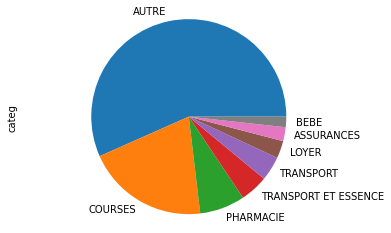

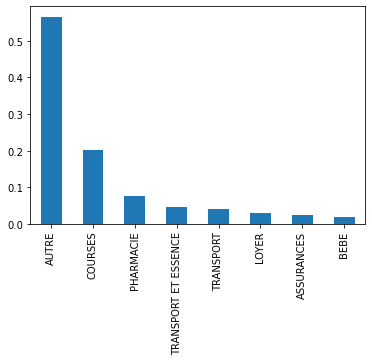

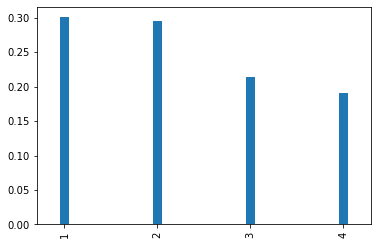

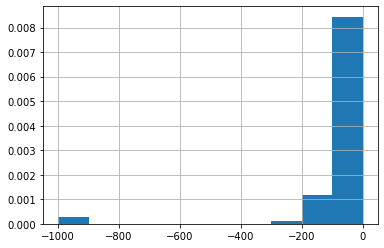

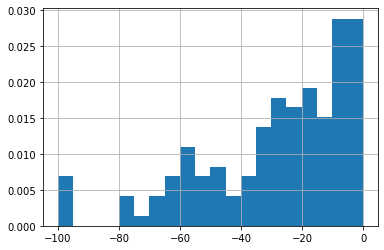

In [55]:
import matplotlib.pyplot as plt

# VARIABLE QUALITATIVE
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()

# VARIABLE QUANTITATIVE
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

# Histogramme
data["montant"].hist(density=True)
plt.show()
# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

In [57]:
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab = pd.DataFrame(modalites, columns = ["quart_mois"]) # création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon

tab = tab.sort_values("quart_mois") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée

--------------------
LOYER
moy:
 -772.6
med:
 -960.0
mod:
 0   -960.0
dtype: float64


--------------------
PHARMACIE
moy:
 -41.849999999999994
med:
 -27.85
mod:
 0    -123.22
1    -113.20
2     -79.00
3     -40.70
4     -34.87
5     -33.93
6     -27.85
7     -22.48
8     -21.80
9     -16.90
10    -16.60
11     -8.00
12     -5.50
dtype: float64


--------------------
COURSES
moy:
 -53.46657142857142
med:
 -31.86
mod:
 0    -152.58
1    -152.40
2    -122.96
3    -117.83
4    -116.65
5    -111.82
6    -107.03
7    -104.82
8     -98.53
9     -96.54
10    -96.46
11    -65.48
12    -53.76
13    -44.09
14    -36.53
15    -35.82
16    -33.50
17    -31.86
18    -30.00
19    -29.50
20    -26.81
21    -22.61
22    -22.19
23    -22.12
24    -18.79
25    -17.87
26    -16.59
27    -16.43
28    -15.67
29    -15.43
30    -12.47
31     -9.60
32     -7.50
33     -6.50
34     -2.59
dtype: float64


--------------------
ASSURANCES
moy:
 -107.28
med:
 -107.28
mod:
 0   -107.28
dtype: float64


--------------------
AUTRE
moy:
 -49.56377551020405
med:
 -26.755000000000003
mod:
 0   -28.0
dtype: float64


--------------------
TRANSPORT ET ESSENCE
moy:
 -42.41375
med:
 -49.224999999999994
mod:
 0   -11.7
dtype: float64


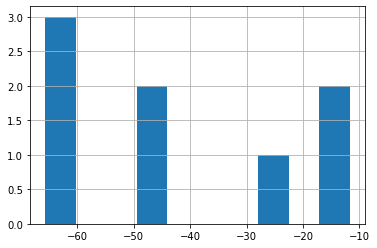

--------------------
TRANSPORT
moy:
 -2.0857142857142854
med:
 -2.2
mod:
 0   -2.2
dtype: float64


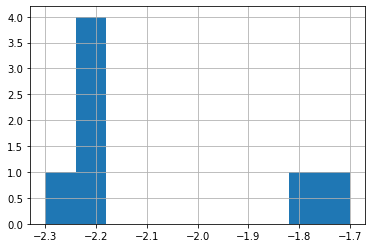

--------------------
BEBE
moy:
 -55.0
med:
 -55.0
mod:
 0   -55.0
dtype: float64


In [63]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat] # Création du sous-échantillon
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    subset["montant"].hist() # Crée l'histogramme
    plt.show() # Affiche l'histogramme
    

--------------------
LOYER
moy:
 -772.6
med:
 -960.0
mod:
 0   -960.0
dtype: float64
var:
 140475.04
ect:
 374.8
skw:
 2.2360679774997894
kur:
 4.999999999999998


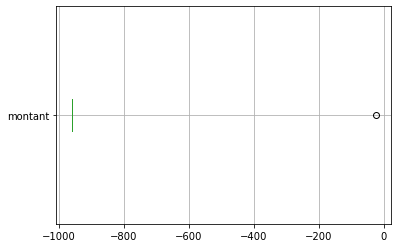

--------------------
PHARMACIE
moy:
 -41.849999999999994
med:
 -27.85
mod:
 0    -123.22
1    -113.20
2     -79.00
3     -40.70
4     -34.87
5     -33.93
6     -27.85
7     -22.48
8     -21.80
9     -16.90
10    -16.60
11     -8.00
12     -5.50
dtype: float64
var:
 1377.3231230769231
ect:
 37.11230420058721
skw:
 -1.3941542508633311
kur:
 0.7707283167918644


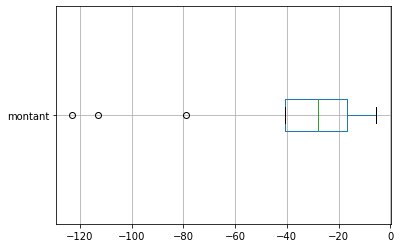

--------------------
COURSES
moy:
 -53.46657142857142
med:
 -31.86
mod:
 0    -152.58
1    -152.40
2    -122.96
3    -117.83
4    -116.65
5    -111.82
6    -107.03
7    -104.82
8     -98.53
9     -96.54
10    -96.46
11    -65.48
12    -53.76
13    -44.09
14    -36.53
15    -35.82
16    -33.50
17    -31.86
18    -30.00
19    -29.50
20    -26.81
21    -22.61
22    -22.19
23    -22.12
24    -18.79
25    -17.87
26    -16.59
27    -16.43
28    -15.67
29    -15.43
30    -12.47
31     -9.60
32     -7.50
33     -6.50
34     -2.59
dtype: float64
var:
 2064.4189882448986
ect:
 45.43587776465751
skw:
 -0.8243002681923226
kur:
 -0.7624344585829723


--------------------
ASSURANCES
moy:
 -107.28
med:
 -107.28
mod:
 0   -107.28
dtype: float64
var:
 0.0
ect:
 0.0
skw:
 0
kur:
 0


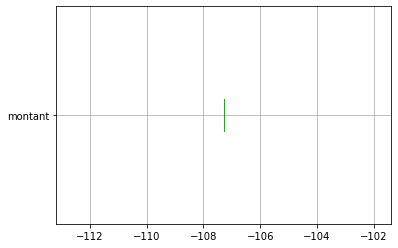

--------------------
AUTRE
moy:
 -49.56377551020405
med:
 -26.755000000000003
mod:
 0   -28.0
dtype: float64
var:
 11469.642901051635
ect:
 107.09641871253976
skw:
 -7.374948120591384
kur:
 63.79578033156064


--------------------
TRANSPORT ET ESSENCE
moy:
 -42.41375
med:
 -49.224999999999994
mod:
 0   -11.7
dtype: float64
var:
 474.96229843750007
ect:
 21.79362976737698
skw:
 0.4667810834307429
kur:
 -1.8345926763285427


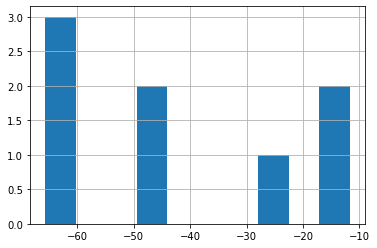

--------------------
TRANSPORT
moy:
 -2.0857142857142854
med:
 -2.2
mod:
 0   -2.2
dtype: float64
var:
 0.04693877551020409
ect:
 0.2166535841157586
skw:
 1.181653122222205
kur:
 -0.4843100189036065


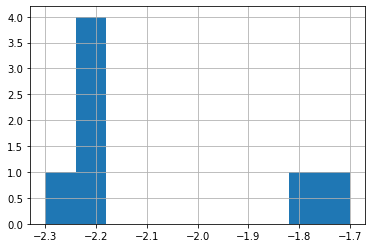

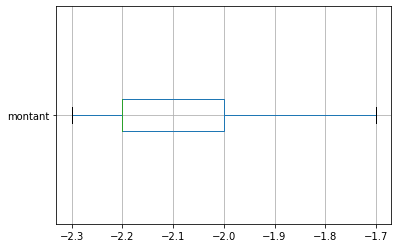

--------------------
BEBE
moy:
 -55.0
med:
 -55.0
mod:
 0   -55.0
dtype: float64
var:
 0.0
ect:
 0.0
skw:
 0
kur:
 nan


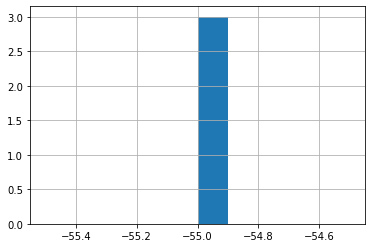

In [62]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    print("skw:\n",subset['montant'].skew())
    print("kur:\n",subset['montant'].kurtosis())
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()